### Example of sampling with pymc3

In [1]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian, plot_decision_boundary
from Neural_Network import NLM,Classifier
import autograd.numpy as np
from sklearn.linear_model import LogisticRegression
from autograd import grad
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc
from sklearn.model_selection import train_test_split
from pandas import get_dummies

In [2]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

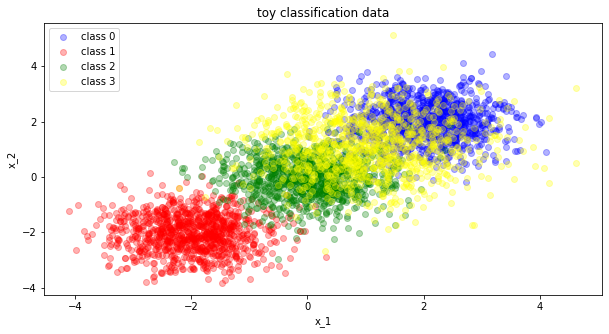

In [3]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params_4 = {'mean': [1, 1], 'covariance_matrix': 1 * np.eye(2)}

params = [params_1, params_2,params_3,params_4]
x, y = two_clusters_gaussian(params, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')
ax.scatter(x[y == 3, 0], x[y == 3, 1], alpha=0.3, color='yellow', label='class 3')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

In [4]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)

In [ ]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)


y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nlm.fit_MLE(X_train.T, y_train.T, params)

Iteration 0 lower bound 1.747347142903652; gradient mag: 1.8855710106602899
Iteration 100 lower bound 1.5230781411157002; gradient mag: 0.501577527597565
Iteration 200 lower bound 1.242989669640642; gradient mag: 0.43135335614113374
Iteration 300 lower bound 0.984111104983343; gradient mag: 0.4293236332574185
Iteration 400 lower bound 0.7779887523478197; gradient mag: 0.36305373083402526
Iteration 500 lower bound 0.6454778188751535; gradient mag: 0.27162260211417366
Iteration 600 lower bound 0.5775292090315525; gradient mag: 0.1970221736625038
Iteration 700 lower bound 0.5392640681474564; gradient mag: 0.1376384924044376
Iteration 800 lower bound 0.5168678286363522; gradient mag: 0.09711903728291375
Iteration 900 lower bound 0.49922080377584366; gradient mag: 0.07491823317820258
Iteration 1000 lower bound 0.485949249891567; gradient mag: 0.05582653715328477
Iteration 1100 lower bound 0.47465849379669434; gradient mag: 0.041558068442058026
Iteration 1200 lower bound 0.4695478860670393; 

### Now I am doing fit.NML manuellement

In [ ]:
from 

In [8]:
import pymc3 as pm
import theano.tensor as T
import autograd.numpy as np
from scipy.special import softmax

def pymc3_sampling_notebook(D, out_last_hidden_layer, output_dim, out_y):
    """
    INPUTS:
    D: dimension of the last hidden layer
    sigma_in: std of the prior (a normal, with mean 0)

    OUTPUTS:
    """
    with pm.Model() as replacing_HMC:  
        # w has a prior: N(0,1) 
        # Output dim number of bias
        w = pm.Normal('w', mu=0, tau=1, shape=(D*output_dim+output_dim)) 
        linear_combinations=[]
        for j in range(output_dim):
            dot=pm.math.dot(out_last_hidden_layer[0].T,w[j*D:j*D+D])+w[-j]
            linear_combi = pm.Deterministic('s'+str(j),dot)
            linear_combinations.append(linear_combi)
        thetas = pm.Deterministic('theta', T.nnet.softmax(linear_combinations))
        # or thetas = pm.Deterministic('theta', pm.math.softmax(linear_combi))?
        # Y commes from a Categorical(thetas)
        y_obs = pm.Categorical('y_obs', p=thetas.T, observed=out_y)
        trace = pm.sample(1000,chains=2)
    return trace

In [9]:
y_train.shape

(3200, 4)

In [ ]:
traces=pymc3_sampling_notebook(5, nlm.forward(nlm.weights,X_train.T,partial=True), 4, y_train.T)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1444 seconds.


In [ ]:
len(traces)

In [ ]:
w_0=[]
w_1=[]
w_2=[]
for i in range(len(traces['w'])):    
    w_0.append(traces['w'][i][0])        
    w_1.append(traces['w'][i][1])        
    w_2.append(traces['w'][i][2])
    
fig, ax=plt.subplots(3,1,figsize=(18,30))
ax[0].plot(range(len(w_0)), w_0, color='b')
ax[1].plot(range(len(w_1)), w_1, color='r')
ax[2].plot(range(len(w_2)), w_2, color='y')

#### Load it from the file

In [ ]:
cd /Users/pellegrinraphael/Desktop/Harvard/AM207/GithubBacoun/Fall/Experiments/

In [ ]:
from Pymc3sampler import pymc3_sampling